# Getting the most solar power for your dollar
## Exploratory Data Analysis
### Zachary Brown

Now that the raw data has been wrangled into a useful dataframe it is time to explore the data and identify correlations and trends that may be important for modeling. 

In [43]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import statsmodels.api as sm 
from statsmodels.graphics.api import abline_plot
from sklearn.model_selection import train_test_split
sns.set_theme('notebook')

In [2]:
print(os.getcwd())
os.chdir(r"..\data\interim")
print(os.getcwd())

C:\Users\Zachary Brown\Documents\GitHub\Solar-Panel-Capstone\notebooks
C:\Users\Zachary Brown\Documents\GitHub\Solar-Panel-Capstone\data\interim


In [3]:
data = pd.read_csv('wrangled_data.csv', index_col=0, low_memory=False)
data.shape

(208257, 57)

In [4]:
data.head()

,data_provider_1,system_id_1,installation_date,system_size_dc,total_installed_price,rebate_or_grant,customer_segment,expansion_system,multiple_phase_system,tracking,...,state_MA,state_MD,state_MN,state_NH,state_NM,state_NY,state_RI,state_TX,state_UT,state_WI
108019,Arizona Public Service,107903,2020-06-17,5.760,17488.26,0.0,RES,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
108020,Arizona Public Service,107904,2020-06-17,8.750,22631.00,0.0,RES,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
108142,Arizona Public Service,108026,2020-06-19,4.725,18972.00,0.0,RES,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
108175,Arizona Public Service,108059,2020-06-22,3.550,9900.00,0.0,RES,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
108233,Arizona Public Service,108117,2020-06-23,5.850,20475.00,0.0,RES,0,0,-1,...,0,0,0,0,0,0,0,0,0,0


In [5]:
data.columns

Index(['data_provider_1', 'system_id_1', 'installation_date', 'system_size_dc',
       'total_installed_price', 'rebate_or_grant', 'customer_segment',
       'expansion_system', 'multiple_phase_system', 'tracking',
       'ground_mounted', 'zip_code', 'city', 'utility_service_territory',
       'third_party_owned', 'installer_name', 'self_installed', 'azimuth_1',
       'tilt_1', 'module_manufacturer_1', 'module_model_1',
       'module_quantity_1', 'additional_modules', 'technology_module_1',
       'bipv_module_1', 'bifacial_module_1', 'nameplate_capacity_module_1',
       'efficiency_module_1', 'inverter_manufacturer_1', 'inverter_model_1',
       'inverter_quantity_1', 'additional_inverters', 'micro_inverter_1',
       'solar_storage_hybrid_inverter_1', 'built_in_meter_inverter_1',
       'dc_optimizer', 'inverter_loading_ratio', 'date_of_battery_install',
       'year', 'month', 'price_per_kw', 'state_AZ', 'state_CA', 'state_CO',
       'state_CT', 'state_DE', 'state_FL', 'state_M

In [6]:
col = data.columns.to_series().groupby(data.dtypes).groups
print(col)

{int64: ['expansion_system', 'multiple_phase_system', 'tracking', 'ground_mounted', 'third_party_owned', 'self_installed', 'module_quantity_1', 'additional_modules', 'bipv_module_1', 'bifacial_module_1', 'additional_inverters', 'micro_inverter_1', 'solar_storage_hybrid_inverter_1', 'built_in_meter_inverter_1', 'dc_optimizer', 'month', 'state_AZ', 'state_CA', 'state_CO', 'state_CT', 'state_DE', 'state_FL', 'state_MA', 'state_MD', 'state_MN', 'state_NH', 'state_NM', 'state_NY', 'state_RI', 'state_TX', 'state_UT', 'state_WI'], float64: ['system_size_dc', 'total_installed_price', 'rebate_or_grant', 'azimuth_1', 'tilt_1', 'nameplate_capacity_module_1', 'efficiency_module_1', 'inverter_quantity_1', 'inverter_loading_ratio', 'year', 'price_per_kw'], object: ['data_provider_1', 'system_id_1', 'installation_date', 'customer_segment', 'zip_code', 'city', 'utility_service_territory', 'installer_name', 'module_manufacturer_1', 'module_model_1', 'technology_module_1', 'inverter_manufacturer_1', 'in

In [7]:
# Year was read in as a float, so I'm going to change that to integer

data['year'] = data['year'].astype(int)

As a first step in this analysis I'm going to take a look at the distribution of the price per KW values for the entire dataset.

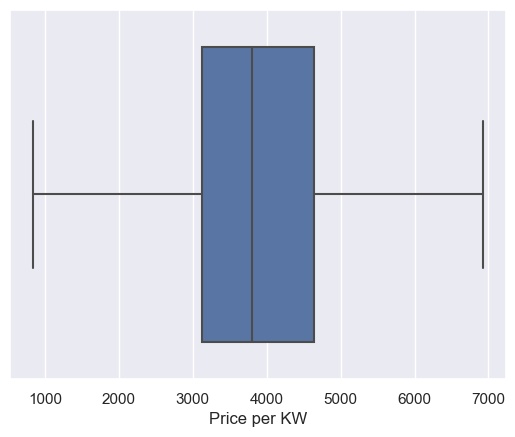

In [23]:
sns.boxplot(x = data['price_per_kw'], showfliers = False)
plt.xlabel('Price per KW')
plt.show()

In [16]:
data['price_per_kw'].describe()

count    2.082570e+05
mean     3.997291e+03
std      6.011821e+03
min     -1.445439e+04
25%      3.120638e+03
50%      3.805405e+03
75%      4.645277e+03
max      2.059954e+06
Name: price_per_kw, dtype: float64

One useful tool to quickly identify a difference in distributions is the empirical cumulative distribution function (ECDF). I'd like to determine whether there are any clear differences in prices per KW in TX versus the rest of the US, so I will first create a function to quickly produce an EDCF for a given column. Then I'll create two new dataframes, one with just TX data, the other with all other states. Then I'll overlay the ECDFs of both to compare. 

In [17]:
def ecdf(column):
    n = len(column)

    # x-data for the ECDF: x
    x = np.sort(column)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

In [18]:
# Creating the two new dataframes
tx = data[data['state_TX'] == 1]
not_tx = data[data['state_TX'] == 0]

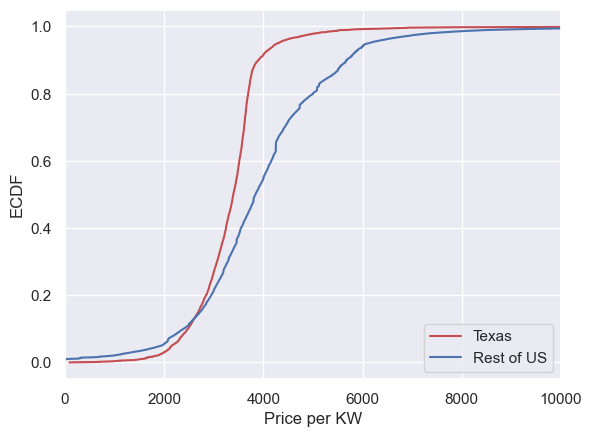

In [24]:
# Plotting the two ECDFs against one another

tx_x, tx_y = ecdf(tx['price_per_kw'])
us_x, us_y = ecdf(not_tx['price_per_kw'])

plt.plot(tx_x, tx_y, color='r')
plt.plot(us_x, us_y, color='b')
plt.xlim(0,10000)
plt.xlabel('Price per KW')
plt.ylabel('ECDF')
plt.legend(['Texas', 'Rest of US'], loc='lower right')
plt.show()

Very interesting! Although the rest of the US has some installations that are more cost efficient than those in Texas, the Texas installations as a whole tend to be more cost efficient than the rest of the country. It seems likely that this will factor into the model later on. Just to confirm whether these results are significantly different, I'll run a two-tailed t-test with the null hypothesis that the mean price per KW of Texas installations and the rest of the US are the same. Before performing the t-test I need to confirm that the data are normally distributed, so I'll perform Shapiro-Wilk tests for normality first. If those results are greater than 0.05 the data is assumed to be normal and I can proceed with the t-test.

In [11]:
scipy.stats.shapiro(tx['price_per_kw'])

C:\Users\Zjbro\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.4929763674736023, pvalue=0.0)

In [12]:
scipy.stats.shapiro(not_tx['price_per_kw'])

ShapiroResult(statistic=0.07287049293518066, pvalue=0.0)

Ok, both sets of data pass the Shapiro-Wilk test, so now I'll run the t-test.

In [13]:
scipy.stats.ttest_ind(tx['price_per_kw'], not_tx['price_per_kw'])

Ttest_indResult(statistic=-8.326852184618529, pvalue=8.35145154071985e-17)

Ok, our t-test confirms that there is a real difference in average cost efficiency between Texas and the rest of the US. That's good to know! I'll keep an eye out for that to show up in the model I generate later.

It seems very possible that pricing may vary throughout the year given seasonal changes in weather. For example one might expect an increase in installations, and hence an increase in price, during the winter or spring so that the panels are ready in time for summer. I'll prepare a series of boxplots of the price per KW broken down by month to get a quick look at whether there is any month to month effect.

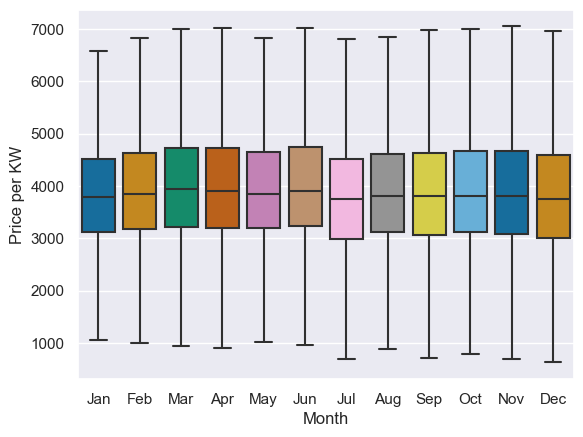

In [25]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

sns.boxplot(x='month', y='price_per_kw', data=data, palette='colorblind', showfliers=False)
plt.xlabel('Month')
plt.xticks(np.arange(12), months)
plt.ylabel('Price per KW')
plt.show()

In [18]:
chi2_month = data[['month', 'price_per_kw']].copy()
chi2_month = chi2_month[chi2_month['month'] >= 0]
chi2_month = chi2_month[chi2_month['price_per_kw'] >= 0]
scipy.stats.chi2_contingency(chi2_month)

(8730078.244294887,
 0.0,
 208250,
 array([[5.14323679e+00, 3.03701301e+03],
        [4.38285412e+00, 2.58801715e+03],
        [6.79852645e+00, 4.01443957e+03],
        ...,
        [6.23827911e+00, 3.68362096e+03],
        [7.69011285e+00, 4.54090950e+03],
        [7.24884450e+00, 4.28034639e+03]]))

Although there isn't a large obvious difference upon visual inspection of the box plots, the chi squared test suggests that there is a significant correlation between the installation month and price efficiency.

Next I want to check for quick correlations in the categorical columns such as 'expansion_system', 'multiple_phase_system', etc. To do so I'll create a loop to automatically make box plots for each.

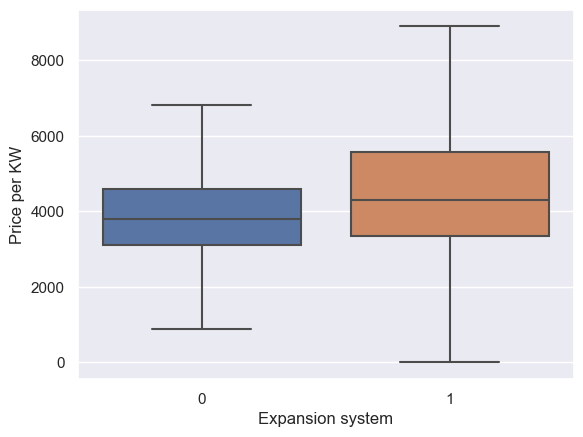

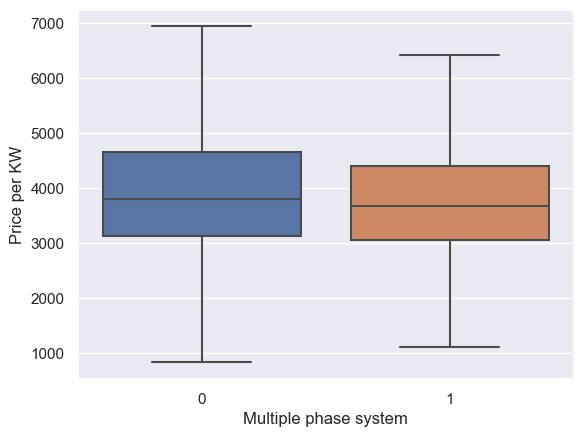

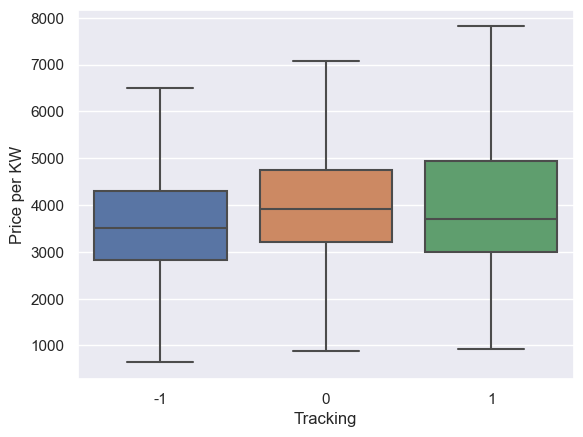

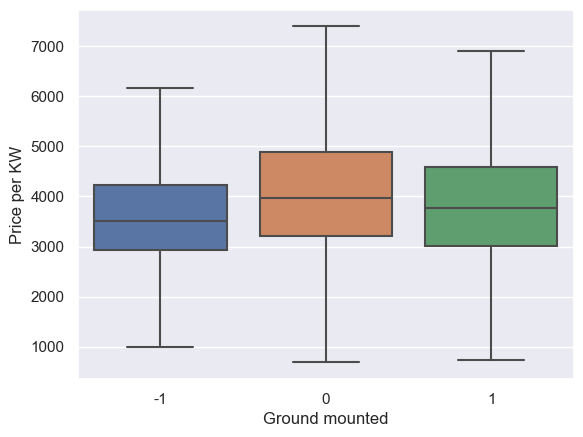

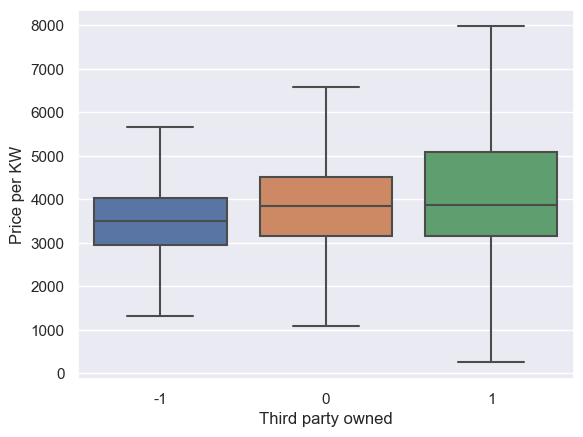

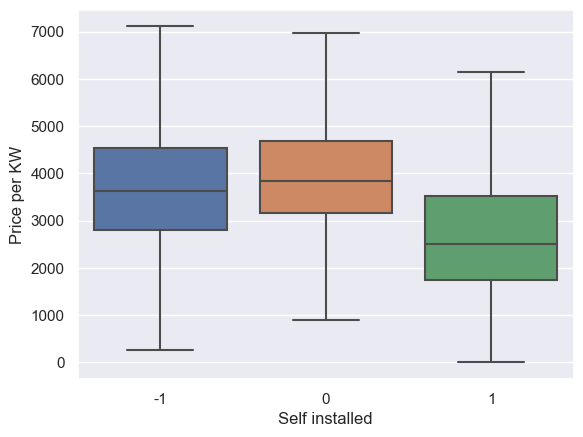

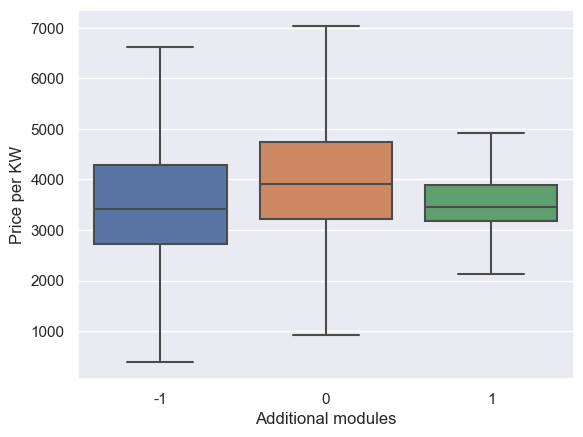

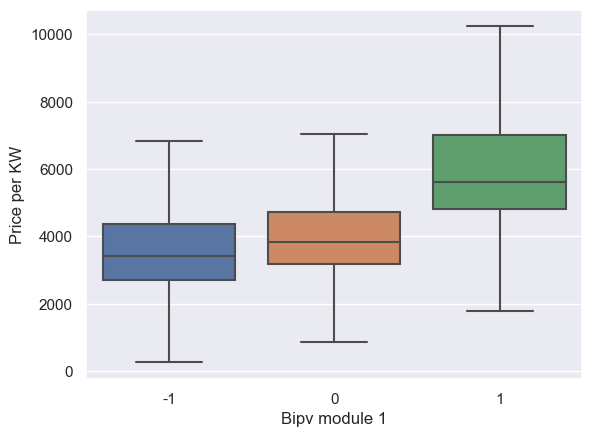

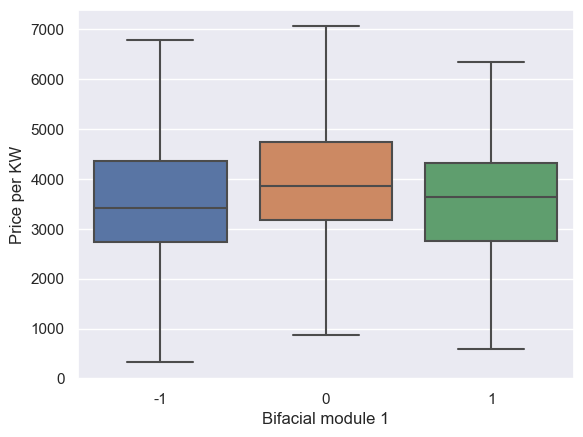

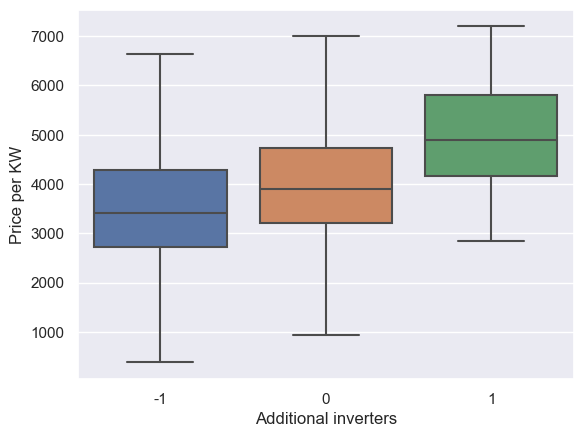

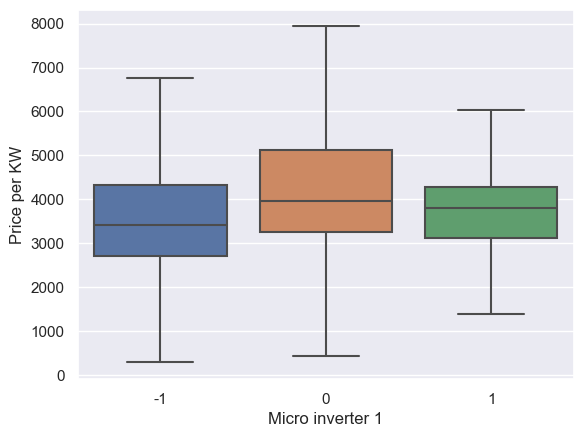

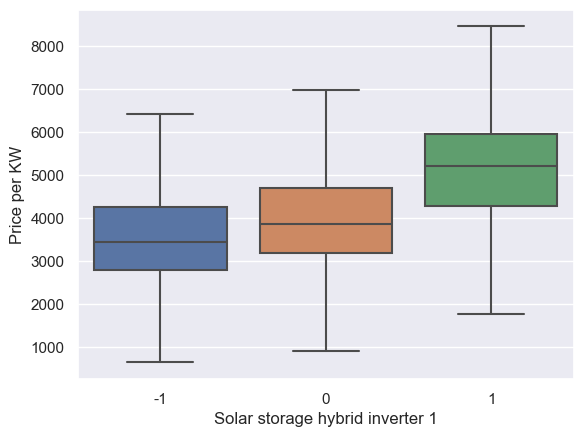

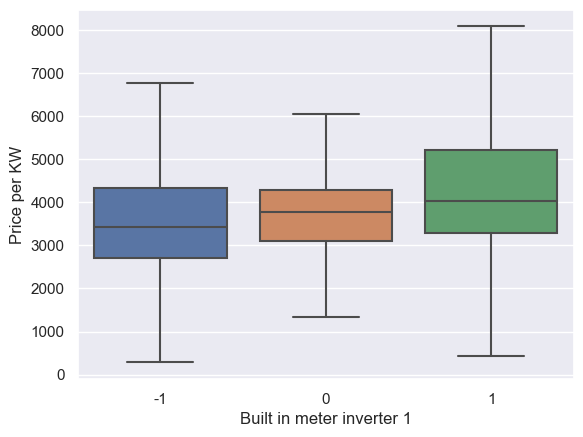

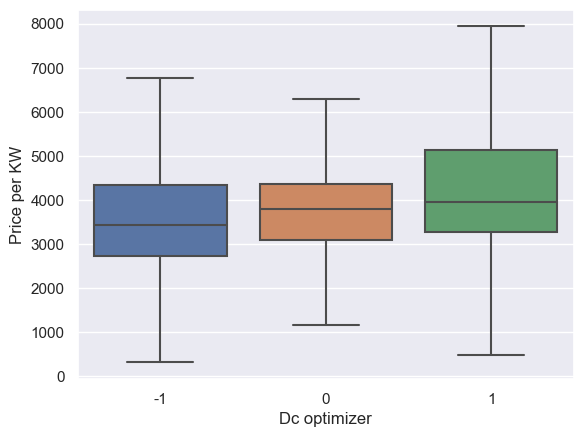

In [26]:
for col in data.columns:
    if data.dtypes[col] == 'int64' and 'state' not in col and 2 not in data[col].unique():
        sns.boxplot(x=col, y='price_per_kw', data=data, showfliers=False)
        plt.xlabel(col.capitalize().replace('_', " "))
        plt.ylabel('Price per KW')
        plt.show()    

While there aren't any plots that show an obvious dramatic difference between their yes (1) and no (0) values, 'self_installed' and 'additional_modules' appear to improve cost efficiency, while 'bipv_module_1', 'additional_inverters', and 'solar_storage_hybrid_inverter_1' all appear to reduce cost efficiency. These may prove important to model development.

I'll go through each of those columns, remove the missing data, split the dataframes by the response to the property of interest, and then perform t-tests to identify whether the mean price per KW is different based on that property.

In [16]:
# self_installed
si_non_null = data[data['self_installed'] != -1]
si_yes = si_non_null[si_non_null['self_installed'] == 1]
si_no = si_non_null[si_non_null['self_installed'] == 0]
print(scipy.stats.ttest_ind(si_yes['price_per_kw'], si_no['price_per_kw']))

Ttest_indResult(statistic=-20.20552291201188, pvalue=1.0841329261436902e-90)


In [17]:
# additional_modules

am_non_null = data[data['additional_modules'] != -1]
am_yes = am_non_null[am_non_null['additional_modules'] == 1]
am_no = am_non_null[am_non_null['additional_modules'] == 0]
print(scipy.stats.ttest_ind(am_yes['price_per_kw'], am_no['price_per_kw']))

Ttest_indResult(statistic=-8.461379495644366, pvalue=2.6628389496148042e-17)


In [18]:
# bipv_module_1 - BIPV stands for building integrated photovoltaic, where the solar panels are designed to blend in with 
# the rest of the building design.

bm1_non_null = data[data['bipv_module_1'] != -1]
bm1_yes = bm1_non_null[bm1_non_null['bipv_module_1'] == 1]
bm1_no = bm1_non_null[bm1_non_null['bipv_module_1'] == 0]
print(scipy.stats.ttest_ind(bm1_yes['price_per_kw'], bm1_no['price_per_kw']))

Ttest_indResult(statistic=12.564814058724114, pvalue=3.410581063393746e-36)


In [19]:
# additional_inverters

ai_non_null = data[data['additional_inverters'] != -1]
ai_yes = ai_non_null[ai_non_null['additional_inverters'] == 1]
ai_no = ai_non_null[ai_non_null['additional_inverters'] == 0]
print(scipy.stats.ttest_ind(ai_yes['price_per_kw'], ai_no['price_per_kw']))

Ttest_indResult(statistic=3.499958896111896, pvalue=0.0004654487524666703)


In [20]:
# solar_storage_hybrid_inverter_1

sshi1_non_null = data[data['solar_storage_hybrid_inverter_1'] != -1]
sshi1_yes = sshi1_non_null[sshi1_non_null['solar_storage_hybrid_inverter_1'] == 1]
sshi1_no = sshi1_non_null[sshi1_non_null['solar_storage_hybrid_inverter_1'] == 0]
print(scipy.stats.ttest_ind(sshi1_yes['price_per_kw'], sshi1_no['price_per_kw']))

Ttest_indResult(statistic=25.927625655684743, pvalue=6.254555956094055e-148)


Great, all of these properties do appear to significantly impact the cost efficiency of the installation as I predicted based on the boxplots. 

Now I want to look for any correlations between the continuous variables and price per KW to see if those play any role here. I'm going to limit the y-axis to the 99.95th percentile of the data to cut out potential outliers which may hide the shape of the bulk data.

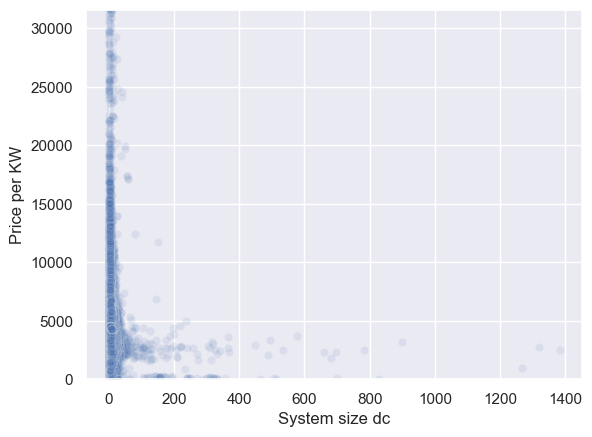

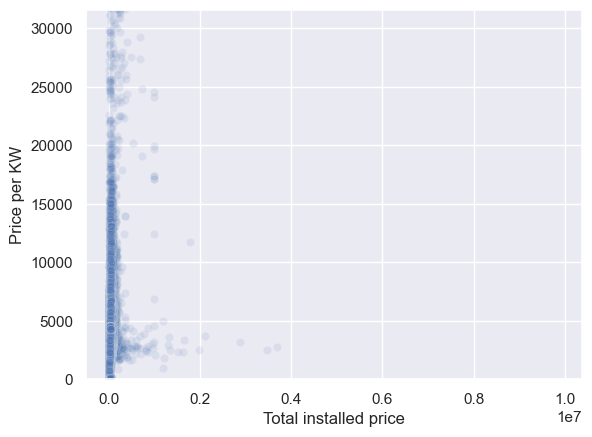

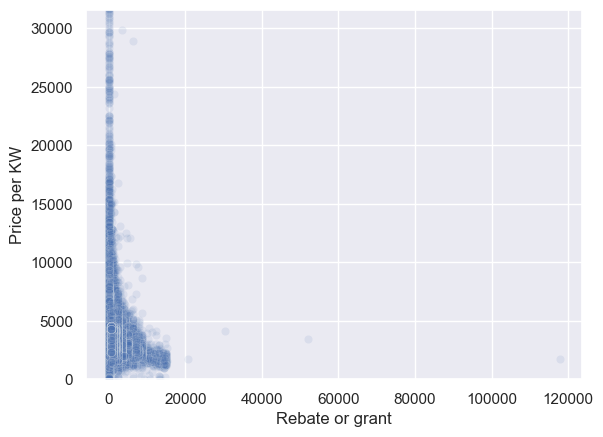

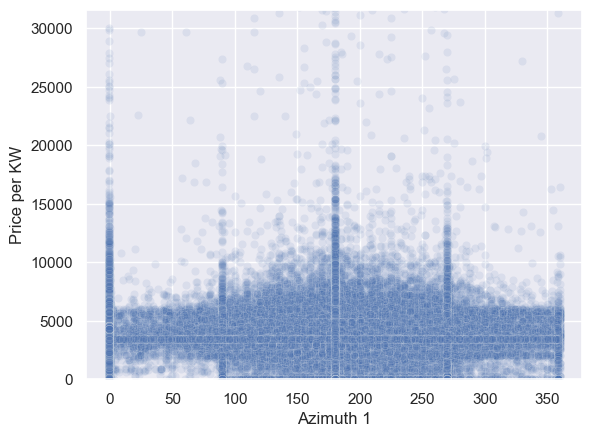

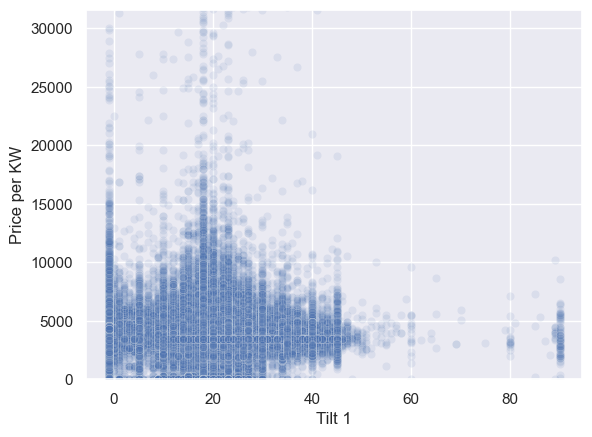

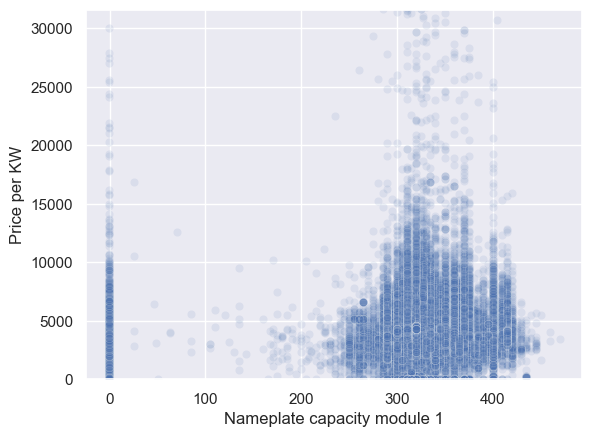

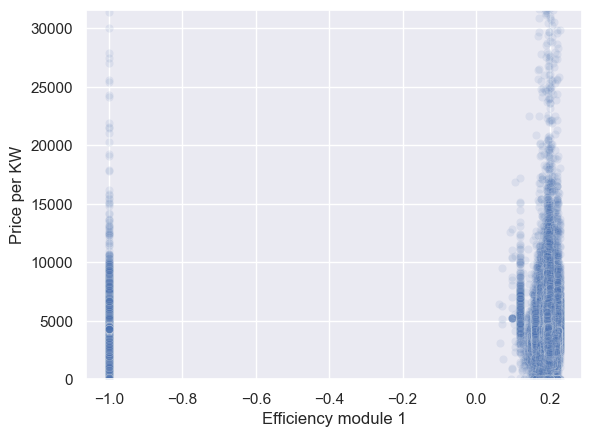

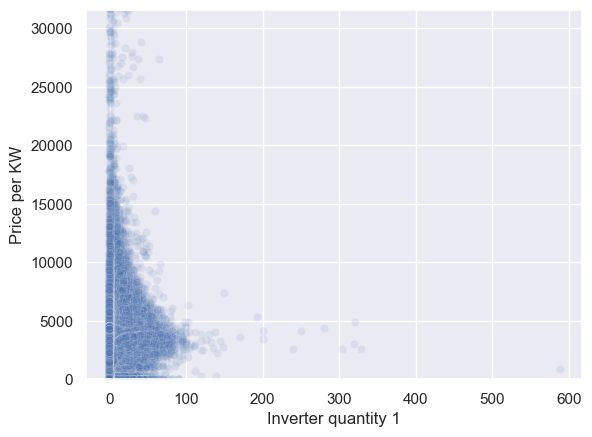

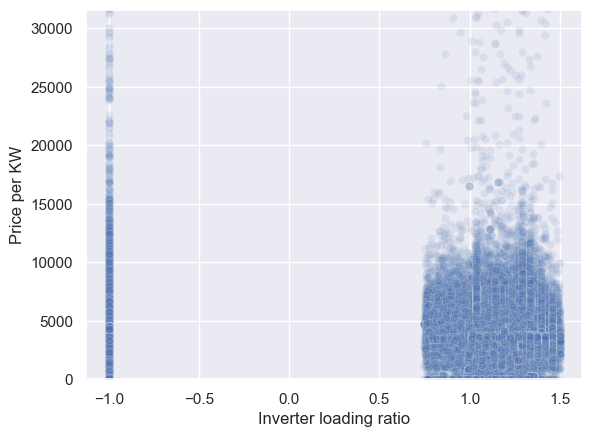

In [27]:
for col in data.select_dtypes('float64').columns:
    if col != 'price_per_kw':
        sns.scatterplot(data=data, x=col, y='price_per_kw', alpha=0.1)
        plt.xlabel(col.capitalize().replace('_', " "))
        plt.ylabel('Price per KW')
        plt.ylim(0, np.quantile(data['price_per_kw'], 0.9995))
        plt.show()

These give an interesting quick look at the data. I want to dig into a few of them a little more. I'll start with efficiency_module_1 by removing missing values, creating an OLS regression of the data, and checking the R-squared value as well as the p-values for the parameters to determine whether the model is a good representation of the data. I'll then overlay the regression line over the data to visually assess the trend.

In [49]:
# First I remove the missing data.
em1_no_null = data[data['efficiency_module_1'] != -1]

dep_em1 = em1_no_null[['price_per_kw']]
ind_em1 = sm.add_constant(em1_no_null[['efficiency_module_1']])

x_train, x_test, y_train, y_test = train_test_split(ind_em1, dep_em1, test_size=0.25)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(137404, 2) (45802, 2) (137404, 1) (45802, 1)


In [54]:
# Now I'll create the model and check the R-squared.
em1_model = sm.OLS(y_train,x_train)
em1_results = em1_model.fit()
em1_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           price_per_kw   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     21.33
Date:                Wed, 02 Nov 2022   Prob (F-statistic):           3.87e-06
Time:                        09:43:50   Log-Likelihood:            -1.3331e+06
No. Observations:              137404   AIC:                         2.666e+06
Df Residuals:                  137402   BIC:                         2.666e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3221.3728    175.112     18.396      0.000    2878.156    3564.590
efficiency_module_1  4070.1044    881.234      4.619      0.000    2342.901    5797.307
==============================================================================
Omnibus:                   689572.187   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   23802089200731.223
Skew:                         218.623   Prob(JB):                         0.00
Kurtosis:                   64479.802   Cond. No.                         85.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
# The R-squared is 0.000, which isn't a good fit for the data. Let's check the slope and intercept parameters.
b, m = em1_results.params
em1_results.params

const                  3221.372801
efficiency_module_1    4070.104371
dtype: float64

In [64]:
# Now I want to see if the parameters have significant p-values.
em1_results.pvalues

const                  1.741992e-75
efficiency_module_1    3.866134e-06
dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

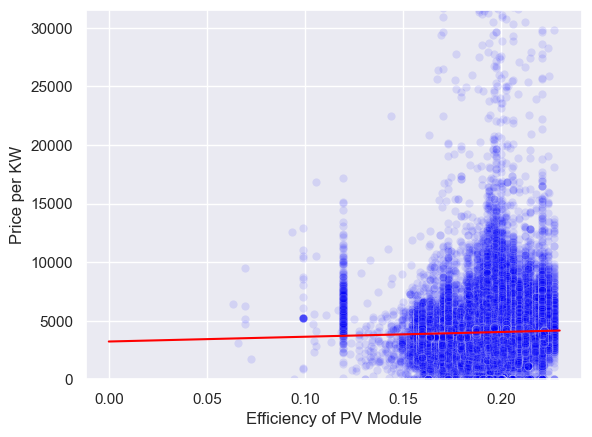

In [65]:
# I'll make the arrays for the regression line.
x=np.array([0, 0.23])
y=(m*x)+b

# And now plot the data with the regression line overlay.
sns.scatterplot(data=em1_no_null, x='efficiency_module_1', y='price_per_kw', alpha = 0.1, color='blue')
plt.plot(x, y, color='red')
plt.ylim(0, np.quantile(em1_no_null['price_per_kw'], 0.9995))
plt.xlabel('Efficiency of PV Module')
plt.ylabel('Price per KW')
plt.show

The regression line has a slight slope to it, but as the R-squared value indicates, the efficiency of the module is not a good representation of the data on its own. 

<function matplotlib.pyplot.show(close=None, block=None)>

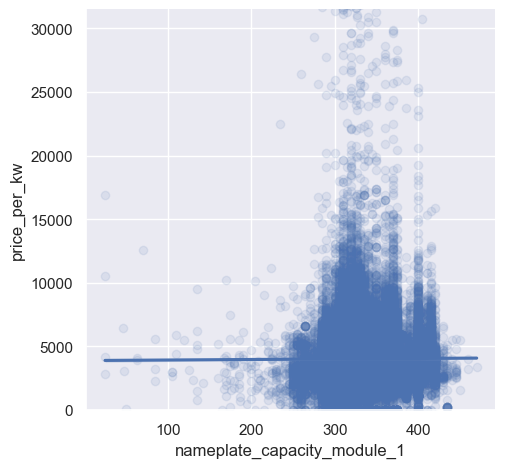

In [29]:
# Nameplate capacity is the maximum output the system can generate

ncm1_no_null = data[data['nameplate_capacity_module_1'] != -1]

sns.lmplot(data=ncm1_no_null, x='nameplate_capacity_module_1', y='price_per_kw', scatter_kws={'alpha': 0.1})
plt.ylim(0, np.quantile(ncm1_no_null['price_per_kw'], 0.9995))
plt.show

This also has a very flat regression line, so I'll leave it there. The last that looks worth checking is inverter_loading_ratio.

<function matplotlib.pyplot.show(close=None, block=None)>

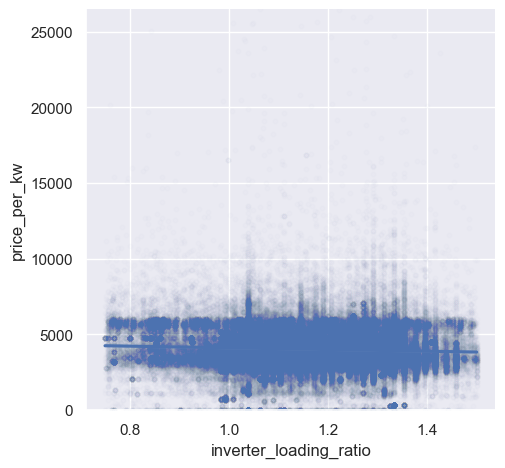

In [30]:
ilr_no_null = data[data['inverter_loading_ratio'] != -1]

sns.lmplot(data=ilr_no_null, x='inverter_loading_ratio', y='price_per_kw', scatter_kws={'alpha': 0.01, 's':10})
plt.ylim(0, np.quantile(ilr_no_null['price_per_kw'], 0.9995))
plt.show

This one is a much more dense plot so it's harder to see the regression line, but it's pretty flat with a slightly negative slope.

One of the last columns I haven't dealt with yet is the date of battery install variable. It's listed as an object type right now, so I'm going to have to check how it's formatted, change it to datetime, break it out to month and year, then check each for any meaningful correlations to cost efficiency.

In [31]:
dobi = data[~data['date_of_battery_install'].isnull()]
print(dobi['date_of_battery_install'].head())

108831    2020-07-10
109237    2020-07-23
109521    2020-07-30
109677    2020-08-04
109819    2020-08-07
Name: date_of_battery_install, dtype: object


In [32]:
dobi_c = dobi.copy()
dobi_c['date_of_battery_install'] = pd.to_datetime(dobi_c['date_of_battery_install'])
dobi_c['month_of_battery_install'] = dobi_c['date_of_battery_install'].dt.month
dobi_c['year_of_battery_install'] = dobi_c['date_of_battery_install'].dt.year

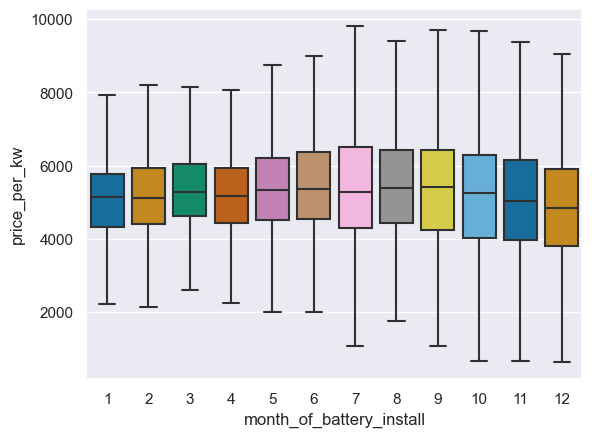

In [33]:
sns.boxplot(x='month_of_battery_install', y='price_per_kw', data=dobi_c, palette='colorblind', showfliers=False)
plt.show()

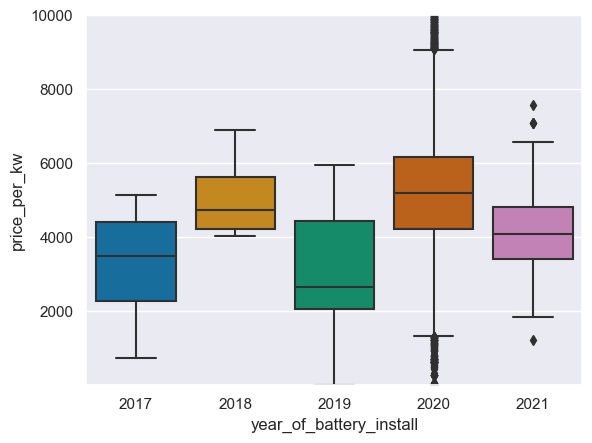

In [34]:
sns.boxplot(x='year_of_battery_install', y='price_per_kw', data=dobi_c, palette='colorblind')
plt.ylim(10, 10000)
plt.show()

Now these are really interesting. It looks like we have more cost efficiency variation when looking at battery installation month than solar panel installation month, and even more interestingly, there are large differences in cost efficiency when split by the year of a battery installation. 

I'll perform chi-squared contingency tests on both to confirm whether the categories of each variable (month and year of battery install) are independent or not.

In [35]:
chi_month = dobi_c[['month_of_battery_install', 'price_per_kw']].copy()
scipy.stats.chi2_contingency(chi_month)

(418970.3381867314,
 0.0,
 13222,
 array([[3.917517, 2944.258954],
        [4.309078, 3238.541738],
        [3.687881, 2771.673701],
        ...,
        [8.878182, 6672.509877],
        [4.154056, 3122.033444],
        [5.978399, 4493.141259]]))

In [36]:
chi_year = dobi_c[['year_of_battery_install', 'price_per_kw']].copy()
scipy.stats.chi2_contingency(chi_year)

(2950511.54237134,
 0.0,
 13222,
 array([[1357.122054, 3604.054417],
        [1437.729759, 3818.121057],
        [1309.848811, 3478.512770],
        ...,
        [2377.789140, 6314.598920],
        [1405.269595, 3731.917905],
        [1783.021424, 4735.098234]]))

In both cases we get very large chi-squared values and p-values of 0.0, meaning that the month and year of battery installation do have an impact on cost efficiency of the solar panel installation.

I'll need to export the updated dataframe for modeling to make sure I capture those broken out date features in the model.

In [37]:
print(os.getcwd())
os.chdir(r"..\processed")
print(os.getcwd())

C:\Users\Zachary Brown\Documents\GitHub\Solar-Panel-Capstone\data\interim
C:\Users\Zachary Brown\Documents\GitHub\Solar-Panel-Capstone\data\processed


In [38]:
dobi_c.to_csv('processed_data.csv')

### Conclusions
As a final wrap-up of this analysis I'll summarize the findings below.

The mean value of price per KW changes significantly based on the value of the following categorical variables:
* state_TX - negative correlation (Texas installations are on average more cost effective than the rest of the US)
* self_installed - negative correlation (self installed units are more cost effective)
* additional_modules - negative correlation
* bipv_module_1 - positive correlation
* additional_inverters - positive correlation
* solar_storage_hybrid_inverter_1 - positive correlation

There were no dramatic linear correlations between the continuous variables and cost efficiency. 

One final interesting finding was that both month and year of battery installation had significant impact on cost efficiency.

These should help me know what to watch for as I develop a model to predict how to optimize cost efficiency in the next step of this capstone.